In [6]:
!pip install transformers
# !pip install wandb
# !pip install pytorch-pretrained-bert==0.4.0
!pip install --upgrade tqdm

In [7]:
import torch
torch.cuda.empty_cache()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup the data set

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
unique_labels = set(['X', '[CLS]', '[SEP]'])

import six

# def convert_to_unicode(text):
#   """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
#   if six.PY3:
#     if isinstance(text, str):
#       return text
#     elif isinstance(text, bytes):
#       return text.decode("utf-8", "ignore")
#     else:
#       raise ValueError("Unsupported string type: %s" % (type(text)))
#   elif six.PY2:
#     if isinstance(text, str):
#       return text.decode("utf-8", "ignore")
#     elif isinstance(text, unicode):
#       return text
#     else:
#       raise ValueError("Unsupported string type: %s" % (type(text)))
#   else:
#     raise ValueError("Not running on Python2 or Python 3?")


class InputExample(object):
  """A single training/test example for simple sequence classification."""

  def __init__(self, guid, text, label=None, segment_ids=None):
    """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.guid = guid
    self.text = text
    self.label = label
    self.segment_ids = segment_ids

# class DataProcessor(object):
#     """Base class for data converters for sequence classification data sets."""

#     def get_train_examples(self, data_dir):
#         """Gets a collection of `InputExample`s for the train set."""
#         raise NotImplementedError()

#     def get_dev_examples(self, data_dir):
#         """Gets a collection of `InputExample`s for the dev set."""
#         raise NotImplementedError()

#     def get_labels(self):
#         """Gets the list of labels for this data set."""
#         raise NotImplementedError()

#     @classmethod
#     def _read_data(cls,input_file):
#         """Read a BIO data!"""
#         rf = open(input_file,'r')
#         lines = [];words = [];labels = []
#         for line in rf:
#             if line.strip().startswith('-DOCSTART-'):
#               continue
#             word = line.strip().split(' ')[0]
#             label = line.strip().split(' ')[-1]
#             # here we dont do "DOCSTART" check
#             try:
#               if len(line.strip())==0 and words[-1] == '.':
#                   l = ' '.join([label for label in labels if len(label) > 0])
#                   w = ' '.join([word for word in words if len(word) > 0])
#                   lines.append((l,w))
#                   words = []
#                   labels = []
#             except IndexError:
#               print(len(word))
#               continue
#             words.append(word)
#             labels.append(label)
#             if len(label) > 0:
#               unique_labels.add(label)
#         rf.close()
#         return lines

# class NerProcessor(DataProcessor):
#     def get_train_examples(self, data_dir):
#         return self._create_example(
#             self._read_data(os.path.join(data_dir, "/content/drive/My Drive/bert-ner/train.txt")), "train"
#         )

#     def get_dev_examples(self, data_dir):
#         return self._create_example(
#             self._read_data(os.path.join(data_dir, "/content/drive/My Drive/bert-ner/valid.txt")), "dev"
#         )

#     def get_test_examples(self,data_dir):
#         return self._create_example(
#             self._read_data(os.path.join(data_dir, "/content/drive/My Drive/bert-ner/test.txt")), "test"
#         )


#     def get_labels(self):
#         """
#         here "X" used to represent "##eer","##soo" and so on!
#         "[PAD]" for padding
#         :return:
#         """
#         return list(unique_labels)

#     def _create_example(self, lines, set_type):
#         examples = []
#         for (i, line) in enumerate(lines):
#             guid = "%s-%s" % (set_type, i)
#             texts = convert_to_unicode(line[1])
#             labels = convert_to_unicode(line[0])
#             examples.append(InputExample(guid=guid, text=texts, label=labels))
#         return examples

In [12]:
def readfile(filename):
    '''
    read file
    '''
    f = open(filename)
    data = []
    sentence = []
    label= []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                data.append((sentence,label))
                sentence = []
                label = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        label.append(splits[-1][:-1])

    if len(sentence) >0:
        data.append((sentence,label))
        sentence = []
        label = []
    return data

class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        return readfile(input_file)


class NerProcessor(DataProcessor):
    """Processor for the CoNLL-2003 data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "/Users/renu/Desktop/Sem_1/CIS_5200/HWs/Final_Project/dataset/train.txt")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "/Users/renu/Desktop/Sem_1/CIS_5200/HWs/Final_Project/dataset/valid.txt")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "/Users/renu/Desktop/Sem_1/CIS_5200/HWs/Final_Project/dataset/test.txt")), "test")

    def get_labels(self):
        return ["O", "B-Quotation","I-Quotation","B-Entity","I-Entity","B-Cue","I-Cue","[CLS]","[SEP]", "X"]
        # return ["O", "B-MISC", "I-MISC",  "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "[CLS]", "[SEP]", "X"]

    def _create_examples(self,lines,set_type):
        examples = []
        for i,(sentence,label) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = ' '.join(sentence)
            label = label
            examples.append(InputExample(guid=guid,text=text_a,label=label))
        return examples

In [13]:
import os
train_examples = NerProcessor().get_train_examples('.')
val_examples = NerProcessor().get_dev_examples('.')
test_examples = NerProcessor().get_test_examples('.')

In [14]:
print(len(train_examples))
print(len(val_examples))
print(len(test_examples))

12116
1889
1119


In [15]:
train_examples[0].label

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [16]:
tags_vals = NerProcessor().get_labels()
label_map = {}
#here start with zero this means that "[PAD]" is zero
for (i,label) in enumerate(tags_vals):
    label_map[label] = i

In [17]:
label_map

{'O': 0,
 'B-Quotation': 1,
 'I-Quotation': 2,
 'B-Entity': 3,
 'I-Entity': 4,
 'B-Cue': 5,
 'I-Cue': 6,
 '[CLS]': 7,
 '[SEP]': 8,
 'X': 9}

In [18]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, BertModel, AdamW, get_linear_schedule_with_warmup

In [19]:
MAX_LEN = 128
bs = 32

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [21]:
#torch.cuda.get_device_name(0) 

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [23]:
def make_feature(input_example):
  text = input_example.text
  label = input_example.label
  word_tokens = ['[CLS]']
  label_list = ['[CLS]']
  label_mask = [0]

  input_ids = [tokenizer.convert_tokens_to_ids('[CLS]')]
  label_ids = [label_map['[CLS]']]

  # iterate over individual tokens and their labels
  for word, label in zip(text.split(), label):
    tokenized_word = tokenizer.tokenize(word)
    
    for token in tokenized_word:
      word_tokens.append(token)
      input_ids.append(tokenizer.convert_tokens_to_ids(token))

    label_list.append(label)
    label_ids.append(label_map[label])
    label_mask.append(1)
    # len(tokenized_word) > 1 only if it splits word in between, in which case
    # the first token gets assigned NER tag and the remaining ones get assigned
    # X
    for i in range(1, len(tokenized_word)):
      label_list.append('X')
      label_ids.append(label_map['X'])
      label_mask.append(0)

  assert len(word_tokens) == len(label_list) == len(input_ids) == len(label_ids) == len(label_mask)

  if len(word_tokens) >= MAX_LEN:
    word_tokens = word_tokens[:(MAX_LEN - 1)]
    label_list = label_list[:(MAX_LEN - 1)]
    input_ids = input_ids[:(MAX_LEN - 1)]
    label_ids = label_ids[:(MAX_LEN - 1)]
    label_mask = label_mask[:(MAX_LEN - 1)]

  assert len(word_tokens) < MAX_LEN, len(word_tokens)

  word_tokens.append('[SEP]')
  label_list.append('[SEP]')
  input_ids.append(tokenizer.convert_tokens_to_ids('[SEP]'))
  label_ids.append(label_map['[SEP]'])
  label_mask.append(0)

  assert len(word_tokens) == len(label_list) == len(input_ids) == len(label_ids) == len(label_mask)

  sentence_id = [0 for _ in input_ids]
  attention_mask = [1 for _ in input_ids]

  while len(input_ids) < MAX_LEN:
    input_ids.append(0)
    label_ids.append(label_map['X'])
    attention_mask.append(0)
    sentence_id.append(0)
    label_mask.append(0)

  assert len(word_tokens) == len(label_list)
  assert len(input_ids) == len(label_ids) == len(attention_mask) == len(sentence_id) == len(label_mask) == MAX_LEN, len(input_ids)
  return word_tokens, label_list, input_ids, label_ids, attention_mask, sentence_id, label_mask

In [24]:
import numpy as np

def setup_data():
  data = {}
  for ds in [('train', train_examples), ('val', val_examples), ('test', test_examples)]:
    input_ids = []
    tags = []
    attention_masks = []
    token_type_ids = []
    raw_text = []
    raw_labels = []
    label_masks = []
    for example in ds[1]:
      word_tokens, label_list, input_id, label_id, attention_mask, sentence_id, label_mask = make_feature(example)
      raw_text.append(word_tokens)
      raw_labels.append(label_list)
      input_ids.append(input_id)
      tags.append(label_id)
      attention_masks.append(attention_mask)
      token_type_ids.append(sentence_id)
      label_masks.append(label_mask)

    data[ds[0]] = {'inputs':torch.LongTensor(input_ids), 'labels':torch.LongTensor(tags), 'mask':torch.LongTensor(attention_masks), 'raw_text':raw_text, 'raw_labels':raw_labels, 'token_type_ids':torch.LongTensor(token_type_ids), 'label_masks':torch.BoolTensor(label_masks)}

  return data

In [25]:
dataset = setup_data()

In [26]:
print("text",dataset['train']['raw_text'][0])
print("label", dataset['train']['raw_labels'][0])
print(dataset['train']['inputs'][0])
print(dataset['train']['labels'][0])
print(dataset['train']['mask'][0])
print(dataset['train']['label_masks'][0])

text ['[CLS]', 'V', '##OL', '##UM', '##E', 'I', 'CHAPTER', 'I', 'Emma', 'Wood', '##house', ',', 'handsome', ',', 'clever', ',', 'and', 'rich', ',', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', ',', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessing', '##s', 'of', 'existence', ';', 'and', 'had', 'lived', 'nearly', 'twenty', '-', 'one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 've', '##x', 'her', '.', '[SEP]']
label ['[CLS]', 'O', 'X', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'X', 'X', 'O', 'X', 'O', 'X', 'O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'X', 'O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'X', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'X', 'O', 'X', '[SEP]']
tensor([  101,   159, 13901, 25810,  2036,   146,  8203,   146,  4913,  5296,
         3255,   117,  8542,   117, 13336,   117,  1105,  3987,   117,  1114,
          170,  6062,  1313,  1105,  

# Setup the model

In [27]:
train_data = TensorDataset(dataset['train']['inputs'], dataset['train']['mask'], dataset['train']['labels'], dataset['train']['token_type_ids'], dataset['train']['label_masks'])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(dataset['val']['inputs'], dataset['val']['mask'], dataset['val']['labels'], dataset['val']['token_type_ids'], dataset['val']['label_masks'])
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(dataset['test']['inputs'], dataset['test']['mask'], dataset['test']['labels'], dataset['test']['token_type_ids'], dataset['test']['label_masks'])
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [28]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import CrossEntropyLoss

class CoNLLClassifier(BertForTokenClassification):
    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, labels=None, label_masks=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids, 
                            head_mask=head_mask)

        sequence_output = outputs[0] #(b, MAX_LEN, 768)
        token_reprs = [embedding[mask] for mask, embedding in zip(label_masks, sequence_output)]
        token_reprs = pad_sequence(sequences=token_reprs, batch_first=True, padding_value=-1) # (b, local_max_len, 768)
        sequence_output = self.dropout(token_reprs)
        logits = self.classifier(sequence_output) # (b, local_max_len, num_labels)
        outputs = (logits,)
        if labels is not None:
            # invalid_label_value = label_map['X']
            labels = [label[mask] for mask, label in zip(label_masks, labels)]
            labels = pad_sequence(labels, batch_first=True, padding_value=-1) #(b, local_max_len)
            loss_fct = CrossEntropyLoss(ignore_index=-1, reduction='sum')
            mask = labels != -1
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss /= mask.float().sum()
            outputs = (loss,) + outputs + (labels, )

        return outputs  # (loss), scores, (hidden_states), (attentions)

In [29]:
model = CoNLLClassifier.from_pretrained("bert-base-cased" , num_labels=len(label_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing CoNLLClassifier: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing CoNLLClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CoNLLClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CoNLLClassifier were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.b

In [31]:
#model = model.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# batch = train_data[:20]
# batch = tuple(t.to('cpu') for t in batch)

In [ ]:
# b_input_ids, b_input_mask, b_labels, b_token_type_ids, b_label_masks = batch
# loss, output, labels = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels, label_masks=b_label_masks)

In [ ]:
# print(loss)
# print(output.size())
# print(labels.size())

In [32]:
num_epochs = 5

num_train_optimization_steps = int(len(train_examples)/bs) * num_epochs
FULL_FINETUNING = True
lr = 3e-5
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

warmup_steps = int(0.1 * num_train_optimization_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=num_train_optimization_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps = num_train_optimization_steps)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
pip install seqeval

  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for seqeval, since package 'wheel' is not installed.
    Running setup.py install for seqeval ... done
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:

from seqeval.metrics import f1_score, accuracy_score, classification_report
from seqeval.scheme import IOB2

# Train!

In [ ]:
from tqdm import tqdm_notebook ,tnrange, trange, tqdm
import torch.nn.functional as F
max_grad_norm = 1.0
import numpy as np

for _ in tnrange(num_epochs, desc="Epoch"):
    # TRAIN loop
    model = model.train()
    tr_loss = 0
    nb_tr_steps = 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader)):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_token_type_ids, b_label_masks = batch
        # forward pass
        loss, logits, labels = model(b_input_ids, token_type_ids=b_token_type_ids,
                     attention_mask=b_input_mask, labels=b_labels, label_masks=b_label_masks)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        scheduler.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    model = model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in tqdm_notebook(valid_dataloader):
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels, b_token_type_ids, b_label_masks = batch
        
        with torch.no_grad():
          tmp_eval_loss, logits, reduced_labels = model(b_input_ids, token_type_ids=b_token_type_ids,
                                  attention_mask=b_input_mask, labels=b_labels, label_masks=b_label_masks)

        logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
        logits = logits.detach().cpu().numpy()
        reduced_labels = reduced_labels.to('cpu').numpy()
        
        labels_to_append = []
        predictions_to_append = []

        for prediction, label in zip(logits, reduced_labels):
          preds = []
          labels = []
          for pred, lab in zip(prediction, label):
            if lab.item() == -1:
              continue
            preds.append(pred)
            labels.append(lab)
          predictions_to_append.append(preds)
          labels_to_append.append(labels)
        
        predictions.extend(predictions_to_append)
        true_labels.append(labels_to_append)
        # print(logits.shape, label_ids.shape, b_input_mask.size())
        
        eval_loss += tmp_eval_loss.mean().item()
        
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("Seq eval accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("F1-Score: {}".format(f1_score([valid_tags], [pred_tags], scheme=IOB2)))
    print("Classification report: -- ")
    print(classification_report([valid_tags], [pred_tags], scheme=IOB2))

<ipython-input-40-06101c3b9174>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(num_epochs, desc="Epoch"):


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-40-06101c3b9174>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/368 [00:00<?, ?it/s]

Train loss: 0.33160976618218346


<ipython-input-40-06101c3b9174>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(valid_dataloader):


  0%|          | 0/38 [00:00<?, ?it/s]

Validation loss: 0.16444004488814817
Seq eval accuracy: 0.9622040744125712
F1-Score: 0.6735024284943335
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.89      0.70      0.78       207
      Entity       0.59      0.44      0.50       320
   Quotation       0.76      0.71      0.73       479

   micro avg       0.74      0.62      0.67      1006
   macro avg       0.75      0.61      0.67      1006
weighted avg       0.73      0.62      0.67      1006



  0%|          | 0/368 [00:00<?, ?it/s]

Train loss: 0.037421572119416414


  0%|          | 0/38 [00:00<?, ?it/s]

Validation loss: 0.14870744681990655
Seq eval accuracy: 0.9647395265190601
F1-Score: 0.7091108671789242
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.90      0.69      0.78       207
      Entity       0.71      0.51      0.59       320
   Quotation       0.80      0.71      0.75       479

   micro avg       0.79      0.64      0.71      1006
   macro avg       0.80      0.64      0.71      1006
weighted avg       0.79      0.64      0.71      1006



  0%|          | 0/368 [00:00<?, ?it/s]

Train loss: 0.01851591336012264


  0%|          | 0/38 [00:00<?, ?it/s]

Validation loss: 0.13192948591160147
Seq eval accuracy: 0.9700757687431822
F1-Score: 0.7472642001042209
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.89      0.74      0.81       207
      Entity       0.72      0.60      0.65       320
   Quotation       0.78      0.78      0.78       479

   micro avg       0.79      0.71      0.75      1006
   macro avg       0.80      0.71      0.75      1006
weighted avg       0.79      0.71      0.75      1006



  0%|          | 0/368 [00:00<?, ?it/s]

Train loss: 0.009036705902674483


  0%|          | 0/38 [00:00<?, ?it/s]

Validation loss: 0.16148499395747326
Seq eval accuracy: 0.9681889206639347
F1-Score: 0.7393753200204813
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.89      0.74      0.81       207
      Entity       0.64      0.61      0.62       320
   Quotation       0.80      0.78      0.79       479

   micro avg       0.76      0.72      0.74      1006
   macro avg       0.77      0.71      0.74      1006
weighted avg       0.77      0.72      0.74      1006



  0%|          | 0/368 [00:00<?, ?it/s]

Train loss: 0.005499102149532637


  0%|          | 0/38 [00:00<?, ?it/s]

Validation loss: 0.18683867370954862
Seq eval accuracy: 0.9681299566614582
F1-Score: 0.743723849372385
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.89      0.74      0.81       207
      Entity       0.70      0.58      0.63       320
   Quotation       0.79      0.78      0.79       479

   micro avg       0.78      0.71      0.74      1006
   macro avg       0.79      0.70      0.74      1006
weighted avg       0.78      0.71      0.74      1006



In [ ]:
model = model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []
for batch in tqdm_notebook(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels, b_token_type_ids, b_label_masks = batch
    
    with torch.no_grad():
      tmp_eval_loss, logits, reduced_labels = model(b_input_ids, token_type_ids=b_token_type_ids,
                              attention_mask=b_input_mask, labels=b_labels, label_masks=b_label_masks)

    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    reduced_labels = reduced_labels.to('cpu').numpy()
    
    labels_to_append = []
    predictions_to_append = []

    for prediction, label in zip(logits, reduced_labels):
      preds = []
      labels = []
      for pred, lab in zip(prediction, label):
        if lab.item() == -1:
          continue
        preds.append(pred)
        labels.append(lab)
      predictions_to_append.append(preds)
      labels_to_append.append(labels)
    
    predictions.extend(predictions_to_append)
    true_labels.append(labels_to_append)
    # print(logits.shape, label_ids.shape, b_input_mask.size())
    
    eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
eval_loss = eval_loss/nb_eval_steps
print("Test loss: {}".format(eval_loss))
pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
print("Seq eval accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
print("F1-Score: {}".format(f1_score([valid_tags], [pred_tags], scheme=IOB2)))
print("Classification report: -- ")
print(classification_report([valid_tags], [pred_tags], scheme=IOB2))

<ipython-input-41-a25d029dd732>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(test_dataloader):


  0%|          | 0/42 [00:00<?, ?it/s]

Test loss: 0.010917866528048069
Seq eval accuracy: 0.996122926050516
F1-Score: 0.5271317829457365
Classification report: -- 
              precision    recall  f1-score   support

         Cue       0.75      1.00      0.86         9
      Entity       0.46      0.61      0.52        18
   Quotation       0.33      0.61      0.42        23

   micro avg       0.43      0.68      0.53        50
   macro avg       0.51      0.74      0.60        50
weighted avg       0.45      0.68      0.54        50



In [ ]:
# torch.save(model.state_dict(), '/content/drive/My Drive/bert-ner/model.torch')

#BERT Embedding Extraction

In [39]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
#model = model.cuda()
#model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
def get_bert_features(data, model):
  new_data = {}
  for split in ["train","test","val"]:
    new_data[split] = {}
    last_4_concat = []
    last_4_sum = []
    
    for idx, x in enumerate(data[split]['inputs']):    
      with torch.no_grad():
        outputs = model(torch.unsqueeze(x,0).cpu(), torch.tensor([[1]*len(x)]).cpu())
        hidden_states = outputs[2]
        token_embeddings = torch.stack(hidden_states, dim=0).cpu()
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)
        # Extract features from embeddings
        token_vecs_cat = []
        token_vecs_sum = []
        for token in token_embeddings:
          # cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
          # token_vecs_cat.append(cat_vec)
          sum_vec = torch.sum(token[-4:], dim=0)
          token_vecs_sum.append(sum_vec)
        # last_4_concat.append(token_vecs_cat)
        last_4_sum.append(token_vecs_sum)
    for field in ['raw_text','raw_labels', 'labels']:
      new_data[split][field] = dataset[split][field]
    # new_data[split]['concat'] = last_4_concat
    new_data[split]['sum'] = last_4_sum
  return new_data
        



In [77]:
bert_dataset = get_bert_features(dataset, model)

In [78]:
len(bert_dataset['train']['sum'][0])

128

#KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
def format_data(dataset):
  texts, labels, sums, y = [],[],[],[]
  for text, raw_labels, label, sum in zip(dataset['raw_text'],
                                        dataset['raw_labels'],
                                        dataset['labels'],
                                        dataset['sum']
                                        # dataset['concat']
                                        ):
    cut_text = text[1:-1]
    cut_raw_label = raw_labels[1:-1]
    cut_label = label[1:len(cut_text)+1]
    cut_sum  = sum[1:len(cut_text)+1]
    # cut_concat  = concat[1:len(cut_text)+1]
    texts += cut_text
    labels += cut_raw_label
    sums += cut_sum
    # concats += cut_concat
    y += cut_label
  return texts, labels, sums, y
def list_data(dataset):
  for example in dataset:
    yield example.tolist()

In [81]:
text_train, labels_train, X_train_sum, y_train = format_data(bert_dataset['train'])
text_test, labels_test, X_test_sum, y_test = format_data(bert_dataset['test'])
text_val, labels_val, X_val_sum, y_val = format_data(bert_dataset['val'])




In [82]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh = neigh.fit(torch.stack(X_train_sum).numpy(),y_train)

In [83]:
y_pred = neigh.predict(torch.stack(X_val_sum).numpy())

In [84]:
id_to_label = {v:k for k,v in label_map.items()}

In [85]:
y_pred_labels = [id_to_label[y] for y in y_pred]

In [86]:
labels_train[:100]

['O',
 'X',
 'X',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'X',
 'O',
 'X',
 'O',
 'X',
 'O',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'O',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'X',
 'O',
 'X',
 'X',
 'X',
 'O',
 'X',
 'O',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'X',
 'X',
 'O',
 'X',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [87]:
print(classification_report([labels_val],[y_pred_labels],scheme=IOB2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         Cue       0.87      0.82      0.85       280
      Entity       0.52      0.39      0.45       475
   Quotation       0.25      0.42      0.31      4860
           _       0.56      0.47      0.51      5103

   micro avg       0.37      0.45      0.41     10718
   macro avg       0.55      0.53      0.53     10718
weighted avg       0.43      0.45      0.43     10718



In [88]:
y_pred

array([0, 0, 2, ..., 2, 9, 9])

In [89]:
y_train[:10]

[tensor(0),
 tensor(9),
 tensor(9),
 tensor(9),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(9)]

In [90]:
#LOGISTIC REGRESSION

In [91]:
from sklearn.linear_model import LogisticRegression
CLF = LogisticRegression(random_state=0)


In [92]:
text_train, labels_train, X_train_sum, y_train = format_data(bert_dataset['train'])
text_val, labels_val, X_val_sum, y_val = format_data(bert_dataset['val'])

In [93]:
CLF = CLF.fit(torch.stack(X_train_sum).numpy(),y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
y_pred = CLF.predict(torch.stack(X_val_sum).numpy())

In [96]:
id_to_label = {v:k for k,v in label_map.items()}
y_pred_labels_LR = [id_to_label[y] for y in y_pred]

In [97]:
print(classification_report([labels_val],[y_pred_labels_LR],scheme=IOB2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         Cue       0.91      0.86      0.88       280
      Entity       0.71      0.55      0.62       475
   Quotation       0.60      0.70      0.65      4860
           _       0.78      0.71      0.74      5103

   micro avg       0.69      0.70      0.69     10718
   macro avg       0.75      0.70      0.72     10718
weighted avg       0.70      0.70      0.70     10718



In [ ]:
# LOGISTIC REGRESSION ON TEST DATA

In [98]:
y_pred = CLF.predict(torch.stack(X_test_sum).numpy())
id_to_label = {v:k for k,v in label_map.items()}
y_pred_labels_LR_test = [id_to_label[y] for y in y_pred]

In [101]:
print(classification_report([labels_test],[y_pred_labels_LR_test],scheme=IOB2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         Cue       0.84      0.83      0.84       162
      Entity       0.70      0.53      0.60       319
   Quotation       0.52      0.64      0.57      3805
           _       0.75      0.67      0.71      3994

   micro avg       0.62      0.65      0.64      8280
   macro avg       0.70      0.67      0.68      8280
weighted avg       0.64      0.65      0.64      8280



In [102]:
# NAIVE BAYES

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
text_train, labels_train, X_train_sum, y_train = format_data(bert_dataset['train'])
text_test, labels_test, X_test_sum, y_test = format_data(bert_dataset['test'])
text_val, labels_val, X_val_sum, y_val = format_data(bert_dataset['val'])
gnb = GaussianNB()
CLF = gnb.fit(torch.stack(X_train_sum).numpy(),y_train)
y_pred = CLF.predict(torch.stack(X_val_sum).numpy())
#print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))


In [104]:
id_to_label = {v:k for k,v in label_map.items()}
y_pred_labels_NB = [id_to_label[y] for y in y_pred]
print(classification_report([labels_val],[y_pred_labels_NB],scheme=IOB2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         Cue       0.33      0.65      0.44       280
      Entity       0.09      0.78      0.17       475
   Quotation       0.19      0.27      0.22      4860
           _       0.44      0.48      0.46      5103

   micro avg       0.25      0.40      0.31     10718
   macro avg       0.26      0.54      0.32     10718
weighted avg       0.31      0.40      0.34     10718



In [ ]:
# NAIVE BAYES ON TEST DATA

In [105]:
y_pred = CLF.predict(torch.stack(X_test_sum).numpy())

In [106]:
id_to_label = {v:k for k,v in label_map.items()}
y_pred_labels_NB = [id_to_label[y] for y in y_pred]
print(classification_report([labels_test],[y_pred_labels_NB],scheme=IOB2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         Cue       0.39      0.78      0.52       162
      Entity       0.09      0.76      0.16       319
   Quotation       0.19      0.29      0.23      3805
           _       0.54      0.55      0.55      3994

   micro avg       0.29      0.44      0.35      8280
   macro avg       0.30      0.59      0.37      8280
weighted avg       0.36      0.44      0.39      8280



In [2]:
# Bar graph

Number of words in text file : 676302
Number of Quotion words in text file : 114799
Number of Cue words in text file : 3018
Number of Entity words in text file : 5670
Number of unlabelled words in text file : 214669
Quotation/Words 0.33948532629910455
Entity/Words 0.016767409124782643
Cue/Words 0.008924874909804942


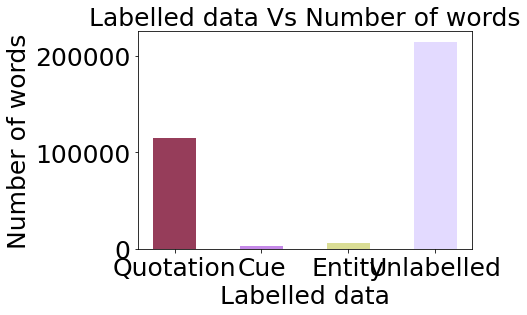

In [5]:
file = open("/Users/renu/Desktop/Sem_1/CIS_5200/HWs/Final_Project/quotation-detection/final/output4.txt", "rt")
data = file.read()
words = data.split()
font = {'family' : 'normal',
        'size'   : 25}
import matplotlib

matplotlib.rc('font', **font)

Q =0
C=0
E =0
N =0
#print(words)
for i in range(len(words)):
    if words[i] == 'I-Quotation' or words[i] =='B-Quotation':
        Q= Q+1
    elif words[i] == 'B-Cue' or words[i] =='I-Cue':
        C = C+1
    elif words[i] == 'B-Entity' or words[i] =='I-Entity':
        E = E+1
    elif words[i] == 'O' or words[i] =='O':
        N = N+1
print('Number of words in text file :', len(words))
print('Number of Quotion words in text file :', Q)
print('Number of Cue words in text file :', C)
print('Number of Entity words in text file :', E)
print('Number of unlabelled words in text file :', N)

print("Quotation/Words",Q/(Q+C+E+N))
print("Entity/Words",E/(Q+C+E+N))
print("Cue/Words",C/(Q+C+E+N))

import matplotlib.pyplot as plt
   
country = ['Quotation', 'Cue', 'Entity', 'Unlabelled']
gdp_per_capita = [114799, 3018, 5670, 214669]
plt.bar(country, gdp_per_capita,color=['#963D5A', '#C589E8', '#DADD95', '#E3DAFF'], width=0.5)
plt.title('Labelled data Vs Number of words', fontsize=25)
plt.xlabel('Labelled data', fontsize=25)
plt.ylabel('Number of words', fontsize=25)
plt.show()

